# EpiWrite — PCA + DEG selection + MultiTaskRidge + DMR Reversal Simulation

**Purpose:**
This notebook performs dimensionality reduction on DMRs (PCA), selects DEGs by paired statistics and annotation (COSMIC optional), trains a **MultiTaskRidge** model to predict multiple DEGs from DMRs, evaluates performance (including LOPO CV), and simulates per-DMR reversal in tumor samples to rank DMRs by predicted impact on DEGs.

**Inputs required (upload in Colab or place in working dir):**
- `X_meth.csv` : Processed data of samples × DMRs (β-values; row index = sample IDs)
- `Y_expr.csv` : Processed data of samples × genes (normalized expression)
- `long_format_tumor_normal_samples.csv`   : sample metadata with columns `sampleID`, `condition` (Tumor/Normal), optional `patientID`
- `DESeq2_paired_DEG_results.csv` : DESeq2 output (diffrencialy expressed gene with columns `baseMean`, `log2FoldChange`, `lfcSE`, `pvalue`, `padj`
- `DMR_definition.csv`: Coordination of each DMR with CpGs it covers (Columns: DMR_ID, chr, start, end, num_CpGs, CpG_IDs)

**Outputs produced:**
- `dmr_causal_rank.csv` (ranked DMRs by mean |ΔY| after simulation)
- `dmr_top_gene_changes.csv` (Genes with most expression change per top DMR)




## 1) Setup & Upload
Run the following cell to upload your files when using Google Colab. If running locally, ensure the files are in the working directory.

In [ ]:
# If running in Colab, use this to upload files. Otherwise ensure files exist in working directory.
try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False
print('IN_COLAB =', IN_COLAB)

if IN_COLAB:
    print('Please upload X_meth.csv, Y_expr.csv, long_format_tumor_normal_samples.csv, DESeq2_paired_DEG_results.csv, DMR_definition.csv')
    uploaded = files.upload()
    print('Uploaded:', list(uploaded.keys()))


IN_COLAB = True
Please upload X_meth.csv, Y_expr.csv, long_format_tumor_normal_samples.csv, DESeq2_paired_DEG_results.csv, DMR_definition.csv


Saving DMR_definition.csv to DMR_definition (1).csv
Saving Y_expr.csv to Y_expr (2).csv
Saving X_meth.csv to X_meth (2).csv
Saving DESeq2_paired_DEG_results.csv to DESeq2_paired_DEG_results (2).csv
Saving long_format_tumor_normal_samples.csv to long_format_tumor_normal_samples (1).csv
Uploaded: ['DMR_definition (1).csv', 'Y_expr (2).csv', 'X_meth (2).csv', 'DESeq2_paired_DEG_results (2).csv', 'long_format_tumor_normal_samples (1).csv']


## 2) Install & Imports

In [ ]:
# Install optional packages if running in Colab (uncomment if needed)
# !pip install --quiet shap gseapy

import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#import sklearn
#from packaging import version
#print("scikit-learn version:", sklearn.__version__)
from sklearn.linear_model import MultiTaskElasticNetCV
#from sklearn.linear_model import MultiTaskRidge
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
print('Imports OK')


Imports OK


## 3) Load data and basic checks

In [ ]:
# Load required files
X = pd.read_csv('X_meth.csv', index_col=0)
Y = pd.read_csv('Y_expr.csv', index_col=0)
meta = pd.read_csv('long_format_tumor_normal_samples.csv')
DMR_def = pd.read_csv('DMR_definition.csv', index_col=0)

# Basic alignment and checks
# Ensure meta has sampleID column
if 'sampleID' not in meta.columns:
    # try common alternatives
    for c in ['sample_id','SampleID','Sample_Id']:
        if c in meta.columns:
            meta = meta.rename(columns={c:'sampleID'})
            break
assert 'sampleID' in meta.columns, 'long_format_tumor_normal_samples.csv must contain sampleID column'
if 'condition' not in meta.columns:
    raise AssertionError('long_format_tumor_normal_samples.csv must contain condition column with Tumor/Normal')

# Set index and align
meta = meta.set_index('sampleID')
common = X.index.intersection(Y.index).intersection(meta.index)
X = X.loc[common].sort_index()
Y = Y.loc[common].sort_index()
meta = meta.loc[common].sort_index()

print('Shapes after alignment:')
print('X (samples x DMRs):', X.shape)
print('Y (samples x genes):', Y.shape)
print('meta:', meta.shape)

# Ensure X in [0,1]
if X.values.min() < -1e-6 or X.values.max() > 1.0 + 1e-6:
    print('Warning: X methylation values appear outside [0,1]. Check inputs.')

# Show counts
print('\nCondition counts:')
print(meta['condition'].value_counts())


Shapes after alignment:
X (samples x DMRs): (47, 824)
Y (samples x genes): (47, 281)
meta: (47, 2)

Condition counts:
condition
Tumor     28
Normal    19
Name: count, dtype: int64


## 4) Top DEG selection: defining a combined score using adj-p-value and log2FoldChange

In [ ]:
deseq_results = pd.read_csv('DESeq2_paired_DEG_results.csv', index_col=0)

# Replace padj=0 with a small number to avoid log(0)
deseq_results['padj'] = deseq_results['padj'].replace(0, 1e-300)

# Combined ranking score
deseq_results['ranking_score'] = -np.log10(deseq_results['padj']) * np.abs(deseq_results['log2FoldChange'])

# Rank genes
ranked_genes = deseq_results.sort_values('ranking_score', ascending=False)
top_40_DEGs = ranked_genes.head(40)
top_40_DEGs.to_csv('top_40_DEGs.csv')



## 5) Prepare Y: filter selected DEGs for the highest ranking DEGs and aligh X and Y


In [ ]:
# Filter Y to include only the top 40 DEGs
Y_model = Y[top_40_DEGs.index]

# Align X and Y after filtering Y
X, Y_model = X.align(Y_model, join="inner", axis=0)

print('Shapes after filtering Y and alignment:')
print('X (samples x DMRs):', X.shape)
print('Y_model (samples x top 40 DEGs):', Y_model.shape)



Shapes after filtering Y and alignment:
X (samples x DMRs): (47, 824)
Y_model (samples x top 40 DEGs): (47, 40)


## 6) Dimensionality reduction on DMRs (PCA)
Reduce predictors by PCA to keep top components explaining ~90% variance or a set number of components.

In [ ]:
# Center methylation? We keep beta values but scale for PCA
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

# Fit PCA and choose n_components by cumulative explained variance
pca = PCA(n_components=0.90, svd_solver='full')  # keep components that explain 90% variance
X_pcs = pca.fit_transform(X_scaled)
print('PCA produced', X_pcs.shape[1], 'components explaining', pca.explained_variance_ratio_.sum())
# convert to DataFrame
X_pcs_df = pd.DataFrame(X_pcs, index=X.index, columns=[f'PC_{i+1}' for i in range(X_pcs.shape[1])])
X_pcs_df.shape


PCA produced 9 components explaining 0.907331766210122


(47, 9)

## 7) Train/Test split and evaluation strategy
We will dfinetune the parameters of MultiTaskElasticNetCV using cros-validation

In [ ]:
# Finetune mode parameters on low dimensional X and Y
#X, Y = X.align(Y, join="inner", axis=0)
X_feat = X_pcs_df.copy()  # predictors
Y_feat = Y_model.copy()

# --- 2️⃣ Split data ---
X_train, X_test, Y_train, Y_test = train_test_split(
    X_feat, Y_feat, test_size=0.2, random_state=42
)

# --- 3️⃣ Normalize gene expression only (optional) ---
expr_scaler = StandardScaler()
Y_train_scaled = expr_scaler.fit_transform(Y_train)
Y_test_scaled = expr_scaler.transform(Y_test)

# --- 4️⃣ MultiTaskElasticNetCV Model ---
enet_cv = MultiTaskElasticNetCV(
    l1_ratio=[0.2, 0.4, 0.6, 0.8, 1.0],
    alphas=np.logspace(-3, 1, 50),
    cv=5,
    max_iter=5000,
    n_jobs=-1,
    random_state=42
)
enet_cv.fit(X_train, Y_train_scaled)

print(f"✅ Optimal alpha: {enet_cv.alpha_:.4f}")
print(f"✅ Optimal l1_ratio: {enet_cv.l1_ratio_}")

# --- 5️⃣ Evaluate model ---
Y_pred_scaled = enet_cv.predict(X_test)
Y_pred = expr_scaler.inverse_transform(Y_pred_scaled)

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("\n📊 Model Performance")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² : {r2:.4f}")


✅ Optimal alpha: 8.2864
✅ Optimal l1_ratio: 0.2

📊 Model Performance
MSE: 0.5593
MAE: 0.5731
R² : 0.6125


## 8) Model: MultiTaskRidge training and evaluation per split

In [ ]:
# Function to compute metrics
from math import sqrt

def compute_metrics(y_true, y_pred):
    # y_true, y_pred are arrays (n_samples, n_outputs)
    mse_per_output = np.mean((y_true - y_pred)**2, axis=0)
    mae_per_output = np.mean(np.abs(y_true - y_pred), axis=0)
    rmse_per_output = np.sqrt(mse_per_output)
    # r2 per output
    r2_per_output = []
    for j in range(y_true.shape[1]):
        try:
            r2_per_output.append(r2_score(y_true[:,j], y_pred[:,j]))
        except Exception:
            r2_per_output.append(np.nan)
    return {
        'mse_mean': float(np.nanmean(mse_per_output)),
        'mae_mean': float(np.nanmean(mae_per_output)),
        'rmse_mean': float(np.nanmean(rmse_per_output)),
        'r2_mean': float(np.nanmean(r2_per_output)),
        'mse_per_output': mse_per_output,
        'r2_per_output': r2_per_output
    }

# CV loop
all_fold_metrics = []
fold = 0
groups = None
if groups is not None and len(set(groups)) > 1:
    logo = LeaveOneGroupOut()
    for train_idx, test_idx in logo.split(X_feat, Y_feat, groups):
        fold += 1
        X_train = X_feat.iloc[train_idx]
        Y_train = Y_feat.iloc[train_idx]
        X_test = X_feat.iloc[test_idx]
        Y_test = Y_feat.iloc[test_idx]
        model = MultiTaskElasticNetCV(l1_ratio=[0.2], alphas=[8.2864], cv=5)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        metrics_dict = compute_metrics(Y_test.values, Y_pred)
        all_fold_metrics.append(metrics_dict)
        print(f'Fold {fold}: MSE={metrics_dict["mse_mean"]:.4f}, MAE={metrics_dict["mae_mean"]:.4f}, R2={metrics_dict["r2_mean"]:.4f}')
else:
    # single train/test
    # Using previously defined X_tr, X_te, Y_tr (note: splits variable created above is dummy)
    model = MultiTaskElasticNetCV(l1_ratio=[0.2], alphas=[8.2864], cv=5)
    model.fit(X_train, Y_train_scaled)
    Y_pred_scaled = model.predict(X_test)
    Y_pred = expr_scaler.inverse_transform(Y_pred_scaled)
    metrics_dict = compute_metrics(Y_test.values, Y_pred)
    all_fold_metrics.append(metrics_dict)
    print('Single split results:', metrics_dict)


# Summarize CV
mse_means = [m['mse_mean'] for m in all_fold_metrics]
mae_means = [m['mae_mean'] for m in all_fold_metrics]
r2_means = [m['r2_mean'] for m in all_fold_metrics]
print('\nOverall CV summary:')
print('MSE mean ± std:', np.mean(mse_means), np.std(mse_means))
print('MAE mean ± std:', np.mean(mae_means), np.std(mae_means))
print('R2 mean ± std:', np.mean(r2_means), np.std(r2_means))

# Retrain final model on entire dataset (for simulation step)
final_model = MultiTaskElasticNetCV(l1_ratio=[0.2], alphas=[8.2864], cv=5)
final_model.fit(X_feat, Y_feat)
print('Final model trained on full dataset')


Single split results: {'mse_mean': 0.5593043880863483, 'mae_mean': 0.5730828220357558, 'rmse_mean': 0.7333603935299875, 'r2_mean': 0.6125346889982609, 'mse_per_output': array([0.3825644 , 0.36047782, 0.68716354, 0.76496065, 0.90056441,
       0.35320893, 0.63109489, 0.57132544, 0.32887593, 1.1162787 ,
       0.57168956, 0.71191572, 0.7712912 , 0.63643793, 0.29180097,
       0.94790824, 0.53608611, 0.60907499, 0.37319774, 0.5584481 ,
       0.40819036, 0.96183926, 0.3733503 , 0.48334346, 0.55803736,
       0.57335891, 0.35895591, 0.40031154, 0.54741219, 0.59804961,
       0.56638011, 0.51603842, 0.34321122, 0.4263267 , 0.4354599 ,
       0.18653951, 0.83925263, 0.41583677, 1.06662265, 0.20929342]), 'r2_per_output': [0.7706309606100646, 0.6393565813630101, 0.33828017428750656, 0.592476477060635, 0.5391165521242606, 0.7750280003596614, 0.3234136364606707, 0.7356794695958446, 0.5265610412794147, 0.5732042693662607, 0.7863275485132195, 0.32785145363300283, 0.36272061566447233, 0.61749614149

## 9) Baseline predictions for tumor samples (before simulation)

In [ ]:
# Define tumor and normal indices
tumor_idx = meta.index[meta['condition'] == 'Tumor']
normal_idx = meta.index[meta['condition'] == 'Normal']

# Predict current tumor expression (raw) using final_model
# We'll predict for tumor samples specifically
X_tumor_pcs = X_pcs_df.loc[tumor_idx]
Y_tumor_pred = pd.DataFrame(final_model.predict(X_tumor_pcs), index=X_tumor_pcs.index, columns=Y_feat.columns)

# Baseline predicted vs actual (for tumor samples)
print('Baseline tumor predictions shape:', Y_tumor_pred.shape)

Baseline tumor predictions shape: (28, 40)


## 10) Simulate per-DMR reversal (replace tumor DMR with mean normal β per DMR) and predict change in DEGs
We will simulate for candidate DMRs (top by variance across tumor).

In [ ]:
# Build normal reference per DMR (mean across normal samples)
normal_ref = X.loc[normal_idx].mean(axis=0).reindex(X.columns)

# Candidate DMR list: choose top_k by variance across tumor or overall
dmr_var = X.loc[tumor_idx].var(axis=0).sort_values(ascending=False)
top_k = min(500, len(dmr_var))
candidate_dmrs = dmr_var.index[:top_k].tolist()
print('Simulating for top', len(candidate_dmrs), 'DMRs by variance')

# Map DMR columns to PCA predictors: we will modify original X_tumor, transform with scaler+pca pipeline
# Helper: given modified X_tumor_raw -> transform using scaler and pca to get X_pcs

def raw_to_pcs(X_raw_df):
    raw_scaled = scaler.transform(X_raw_df)
    pcs = pca.transform(raw_scaled)
    return pd.DataFrame(pcs, index=X_raw_df.index, columns=X_pcs_df.columns)

# Baseline predicted tumor Y (already computed in Y_tumor_pred)

records = []
per_dmr_top_changed_genes = {}
for dmr in candidate_dmrs:
    # copy original tumor raw X
    X_tum_mod = X.loc[tumor_idx].copy()
    # replace this DMR for all tumor samples with normal mean
    X_tum_mod[dmr] = float(normal_ref[dmr])
    # convert to PCs
    X_tum_mod_pcs = raw_to_pcs(X_tum_mod)
    # predict
    Y_mod_pred = pd.DataFrame(final_model.predict(X_tum_mod_pcs), index=X_tum_mod_pcs.index, columns=Y_feat.columns)
    # delta per sample and gene
    delta = (Y_mod_pred - Y_tumor_pred)
    deltaAbs = (Y_mod_pred - Y_tumor_pred).abs()
    mean_change = delta.values.mean()
    mean_abs_change = deltaAbs.values.mean()
    #records.append({'DMR_ID': dmr, 'MeanAbsDeltaY': float(mean_abs_change), 'MeanDeltaY': float(mean_change)})
    records.append({'DMR_ID': dmr, 'MeanAbsDeltaY': float(mean_abs_change)})
    # top genes that changed most (mean across samples)
    #gene_mean_change = delta.mean(axis=0).sort_values(ascending=False)
    gene_mean_change = delta.mean(axis=0).abs().sort_values(ascending=False)
    per_dmr_top_changed_genes[dmr] = gene_mean_change.head(20)

rank_df = pd.DataFrame(records).sort_values('MeanAbsDeltaY', ascending=False).reset_index(drop=True)

# Add DMR coordinations to the results
DMR_def_reset = DMR_def.reset_index()
DMR_def_reset["DMR_ID"] = DMR_def_reset["DMR_ID"].str.replace("^DMR_", "", regex=True)
# Merge rank_df by DMR coordinations
rank_pos_df = rank_df.merge(DMR_def_reset[["DMR_ID", "chr", "start", "end"]], on="DMR_ID", how="left")
# Create combined genomic coordinate column
rank_pos_df["DMR_Locus"] = "chr" + rank_pos_df["chr"].astype(str) + ":" + rank_pos_df["start"].astype(str) + "-" + rank_pos_df["end"].astype(str)
# Drop the separate columns if you only want the formatted one
rank_pos_df_final = rank_pos_df.drop(columns=["chr", "start", "end"])

rank_pos_df_final.head(50).to_csv('dmr_causal_rank.csv', index=False)
print('Saved dmr_causal_rank.csv')
files.download('dmr_causal_rank.csv')
print(rank_pos_df_final.head(20)) # Print the head of the final dataframe instead of just returning it

Simulating for top 500 DMRs by variance
Saved dmr_causal_rank.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   DMR_ID  MeanAbsDeltaY                  DMR_Locus
0     168       0.006843     chr7:27138396-27138751
1     661       0.006757   chr1:247511364-247511469
2     759       0.005903     chr3:11178593-11178798
3     582       0.005862     chr1:18956762-18957232
4     683       0.005741     chr2:63283939-63286355
5      99       0.005705     chr6:29943209-29943480
6     371       0.005638    chr12:52400907-52401523
7     535       0.005635    chr19:10231566-10231711
8     421       0.005504  chr13:114065669-114065897
9     405       0.005489    chr13:41593385-41593519
10    548       0.005482    chr19:52222446-52223099
11    322       0.005465        chr11:393328-393606
12    422       0.005459    chr14:20903410-20903611
13    107       0.005334     chr6:33943662-33943929
14     67       0.005282   chr5:178004012-178004204
15    299       0.005242  chr10:103043991-103044194
16     59       0.005116   chr5:151066460-151066662
17    100       0.005101     chr6:30094980-30095762
18    664   

## 11) Create table listing top reversed DMRs with the most impacted on gene expression

In [92]:
# @title
# Build a summary table: for top N DMRs, list top changed genes and their mean change
top_n = 30
top_dmrs = rank_df['DMR_ID'].head(top_n).tolist()
summary_rows = []
for dmr in top_dmrs:
    changes = per_dmr_top_changed_genes[dmr]
    for gene, val in changes.items():
        summary_rows.append({'DMR_ID': dmr, 'Gene': gene, 'MeanAbsDeltaGene': float(val)})
summary_df = pd.DataFrame(summary_rows)

# Add DMR coordinations to the results
summary_pos_df = summary_df.merge(DMR_def_reset[["DMR_ID", "chr", "start", "end"]], on="DMR_ID", how="left")
# Create combined genomic coordinate column
summary_pos_df["DMR_Locus"] = "chr" + summary_pos_df["chr"].astype(str) + ":" + summary_pos_df["start"].astype(str) + "-" + summary_pos_df["end"].astype(str)
# Drop the separate columns if you only want the formatted one
summary_df_final = summary_pos_df.drop(columns=["chr", "start", "end"])

summary_df_final.to_csv('dmr_top_gene_changes.csv', index=False)
print('Saved dmr_top_gene_changes.csv')
files.download('dmr_top_gene_changes.csv')
print()
print('Genes with the highest up/down regulation after DMR reprogramming from Tumor to Normal')
summary_df_final.nlargest(n=600, columns='MeanAbsDeltaGene').groupby('Gene').head(1).head(10)


Saved dmr_top_gene_changes.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Genes with the highest up/down regulation after DMR reprogramming from Tumor to Normal


,DMR_ID,Gene,MeanAbsDeltaGene,DMR_Locus
0,168,CXCL13,0.019096,chr7:27138396-27138751
281,67,KRT16,0.014430,chr5:178004012-178004204
380,381,ADCY8,0.014280,chr12:54423428-54424679
1,168,PITX1,0.012827,chr7:27138396-27138751
560,265,MYEOV,0.012377,chr8:104153592-104153643
2,168,FAM83A,0.012289,chr7:27138396-27138751
62,582,ANGPT4,0.011479,chr1:18956762-18957232
22,661,RS1,0.010917,chr1:247511364-247511469
23,661,CYP24A1,0.010388,chr1:247511364-247511469
541,768,ZYG11A,0.010358,chr3:112051894-112052405



## 12) Results
- Bar plot of top DMRs with the most impact on mean gene expression
- Heatmap of mean gene expression changes for the top DMRs

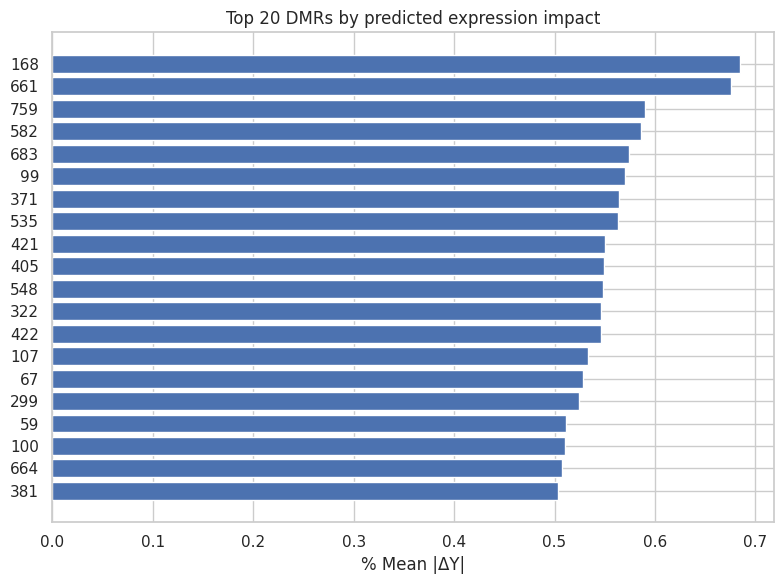

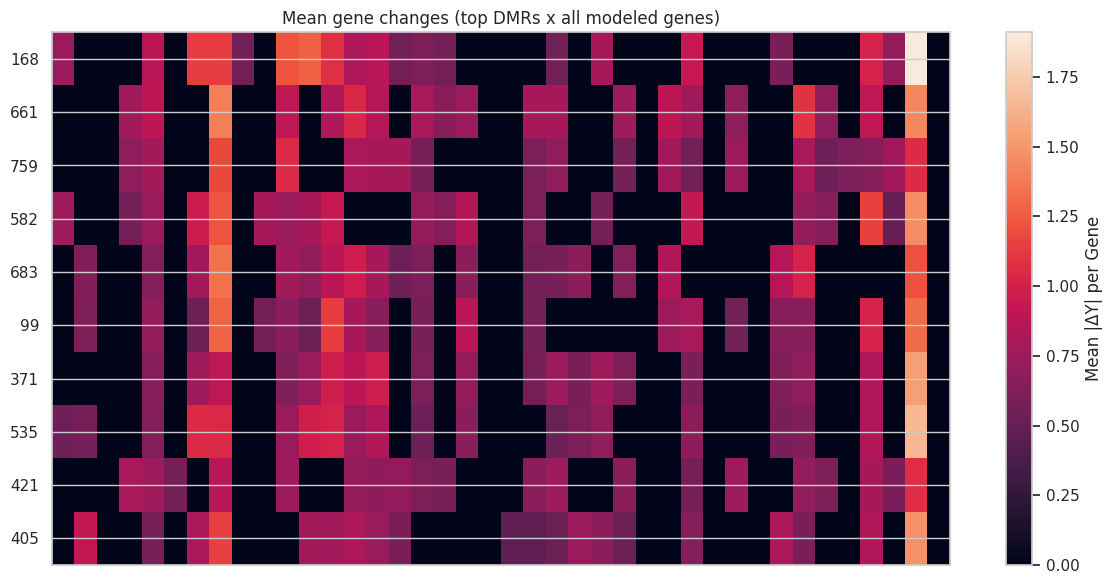

In [ ]:
# @title
import matplotlib.pyplot as plt
import numpy as np

# Bar plot
plt.figure(figsize=(8,6))
plt.barh(rank_df['DMR_ID'].head(20), 100 * rank_df['MeanAbsDeltaY'].head(20))
plt.gca().invert_yaxis()
plt.xlabel('% Mean |ΔY|')
plt.title('Top 20 DMRs by predicted expression impact')
plt.tight_layout(); plt.show()

# Heatmap for top DMRs x top genes
heat_dmrs = rank_df['DMR_ID'].head(10).tolist()
heat_mat = []
for dmr in heat_dmrs:
    vec = 100 * (per_dmr_top_changed_genes[dmr].reindex(Y_feat.columns).fillna(0).values)
    heat_mat.append(vec)
heat_mat = np.vstack(heat_mat)
plt.figure(figsize=(12,6))
plt.imshow(heat_mat, aspect='auto', interpolation='nearest')
plt.colorbar(label='Mean |ΔY| per Gene')
plt.yticks(range(len(heat_dmrs)), heat_dmrs)
plt.xticks([])
plt.title('Mean gene changes (top DMRs x all modeled genes)')
plt.tight_layout(); plt.show()
